In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import argparse
import re
from pathlib import Path
import matplotlib
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from astropy.coordinates import SkyCoord
import astropy.units as u

import h5py
import healpy as hp

from scipy.special import legendre # Legendre functions P_l(x)

# Getting the real GRBs data here

In [9]:
#Load the data
file_path = "Summary_table.txt"   # Update this if needed with your path
df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
df.columns = [
    "GRB_Name", "Trigger", "Trigger_Time", "RA_deg", "Dec_deg", "pos_err", "duration",
    "col7", "col8", "col9", "col10", "z", "col12", "col13", "col14"
] ## name those as required for your work

/tmp/ipykernel_865/710015884.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)


## Data and filters

In [10]:
ra = df["RA_deg"].to_numpy(dtype=float)
dec = df["Dec_deg"].to_numpy(dtype=float)
pos_err = df["pos_err"].to_numpy(dtype=float)
duration = df["duration"].to_numpy(dtype=float)
z = df["z"].to_numpy(dtype=float)
mask = np.isfinite(ra) & np.isfinite(dec) & (ra != -999) & (dec != -999)
ra, dec = ra[mask], dec[mask]
# mask the other parameters as needed
pos_err = pos_err[mask]
duration = duration[mask]
z = z[mask]
# filter out the invalid duration values
valid_duration_mask = np.isfinite(duration) & (duration != -999)
ra = ra[valid_duration_mask]
dec = dec[valid_duration_mask]
pos_err = pos_err[valid_duration_mask]
duration = duration[valid_duration_mask]
z = z[valid_duration_mask]

# filter out the invalid pos_err values
valid_pos_err_mask = np.isfinite(pos_err) & (pos_err != -999)
ra = ra[valid_pos_err_mask]
dec = dec[valid_pos_err_mask]
pos_err = pos_err[valid_pos_err_mask]
duration = duration[valid_pos_err_mask]
z = z[valid_pos_err_mask]   
coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame="icrs")
x = (360.0 * u.deg - coords.ra).wrap_at(180 * u.deg).radian
y = coords.dec.radian

# separate short and long GRBs
short_mask = duration < 2.0
long_mask = duration >= 2.0
x_short, y_short = x[short_mask], y[short_mask]
x_long, y_long = x[long_mask], y[long_mask]
print(len(x_short), len(x_long))
pos_err_short = pos_err[short_mask]
pos_err_long = pos_err[long_mask]
z_short = z[short_mask]
z_long = z[long_mask]

1262 6283


41.5622902584493 0.008 2100.0


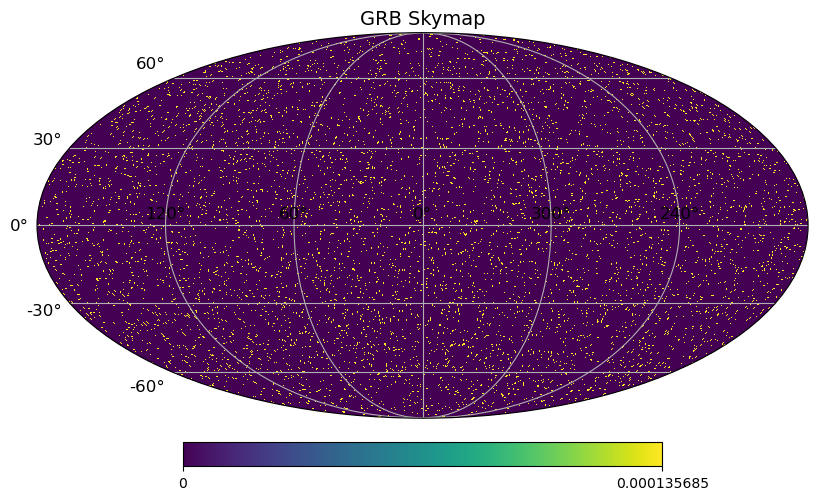

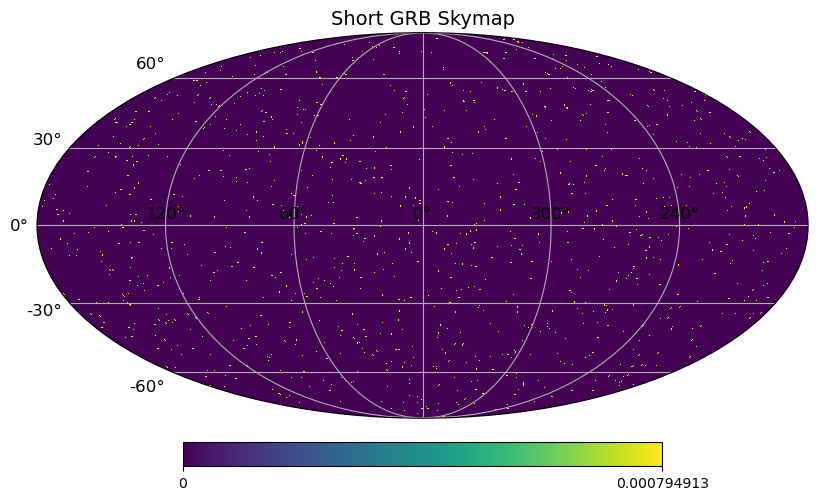

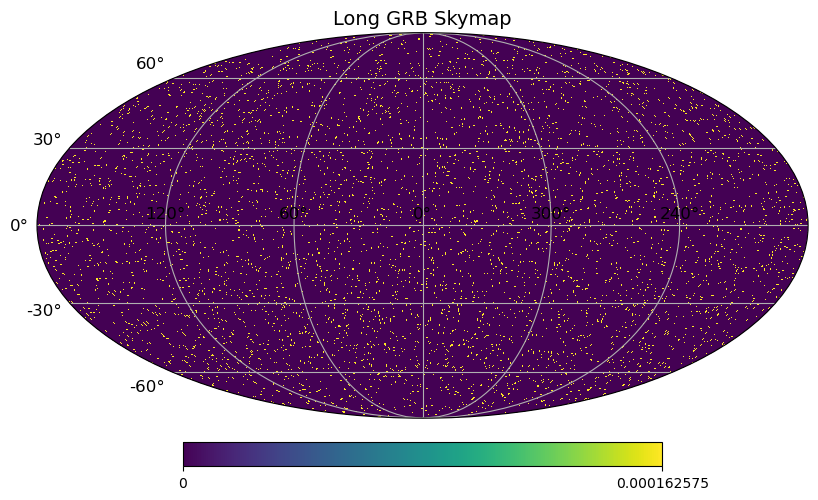

In [11]:
# get the real events here
# # Filter for valid burst duration and sky position error

df_filt = df[(df['duration']>=0) & (df['pos_err']>=0)]

print(df_filt['duration'].mean(), df_filt['duration'].min(), df_filt['duration'].max())

len(df_filt)

# creating healpy skymap object for GRB distribution (all T90≥0 and pos_err≥0, regardless of redshift)

nside = 128

lon_deg = df_filt['RA_deg'].to_numpy()
lat_deg = df_filt['Dec_deg'].to_numpy()

lon_rad = np.radians(lon_deg)
lat_rad = np.radians(lat_deg)

ipix = hp.ang2pix(nside, lat_rad + np.pi/2, lon_rad + np.pi, nest=False)

npix = hp.nside2npix(nside)
GRB_full_sm = np.zeros(npix)

for i, pixel_index in enumerate(ipix):
    GRB_full_sm[pixel_index] = 1.0  # Or your actual data value

# normalize map
GRB_full_sm = GRB_full_sm / (GRB_full_sm.sum())

hp.projview(
    GRB_full_sm,
    norm="hist",
    graticule = True,
    graticule_labels = True,
    title='GRB Skymap',
    projection_type='mollweide',
    min=0)

# plot the skymap for the long GRBs and short GRBs separately
# Short GRBs
lon_deg_short = df_filt[short_mask]['RA_deg'].to_numpy()
lat_deg_short = df_filt[short_mask]['Dec_deg'].to_numpy()
lon_rad_short = np.radians(lon_deg_short)
lat_rad_short = np.radians(lat_deg_short)
ipix_short = hp.ang2pix(nside, lat_rad_short + np.pi/2, lon_rad_short + np.pi, nest=False)
GRB_short_sm = np.zeros(npix)
for i, pixel_index in enumerate(ipix_short):
    GRB_short_sm[pixel_index] = 1.0  # Or your actual data value
# normalize map
GRB_short_sm = GRB_short_sm / (GRB_short_sm.sum())
hp.projview(
    GRB_short_sm,
    norm="hist",
    graticule = True,
    graticule_labels = True,
    title='Short GRB Skymap',
    projection_type='mollweide',
    min=0)

# Long GRBs
lon_deg_long = df_filt[long_mask]['RA_deg'].to_numpy()
lat_deg_long = df_filt[long_mask]['Dec_deg'].to_numpy()
lon_rad_long = np.radians(lon_deg_long)
lat_rad_long = np.radians(lat_deg_long)
ipix_long = hp.ang2pix(nside, lat_rad_long + np.pi/2, lon_rad_long + np.pi, nest=False)
GRB_long_sm = np.zeros(npix)
for i, pixel_index in enumerate(ipix_long):
    GRB_long_sm[pixel_index] = 1.0  # Or your actual data value
# normalize map
GRB_long_sm = GRB_long_sm / (GRB_long_sm.sum())
hp.projview(
    GRB_long_sm,
    norm="hist",
    graticule = True,
    graticule_labels = True,
    title='Long GRB Skymap',
    projection_type='mollweide',
    min=0)  


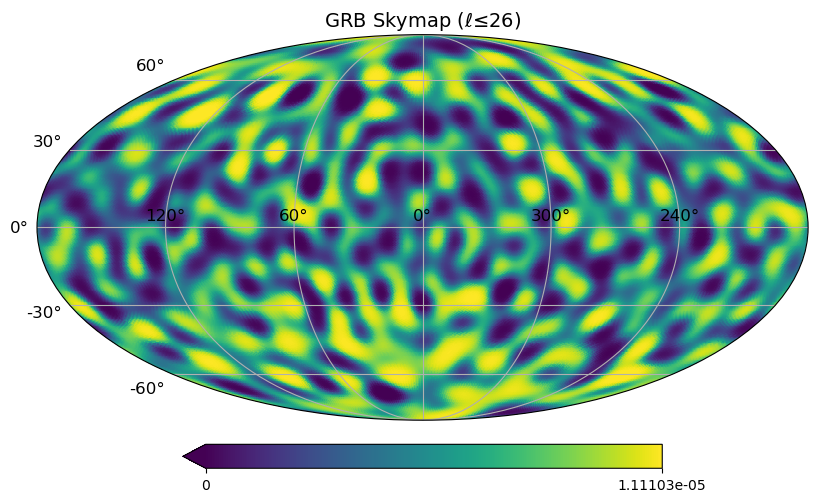

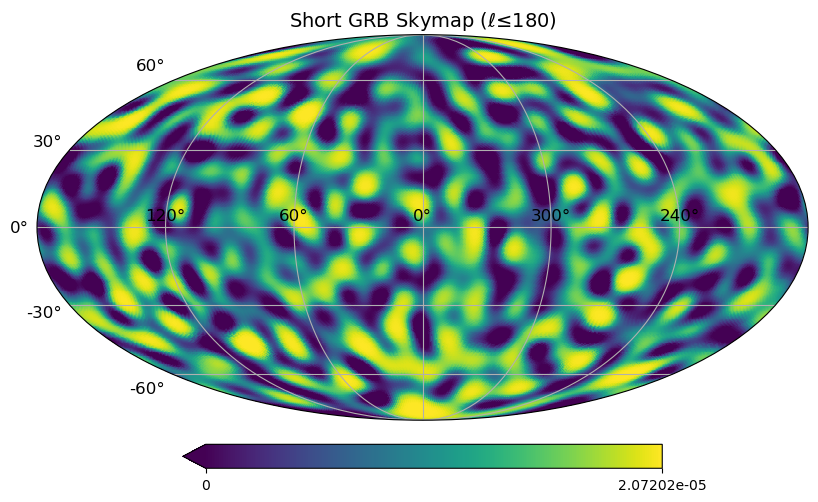

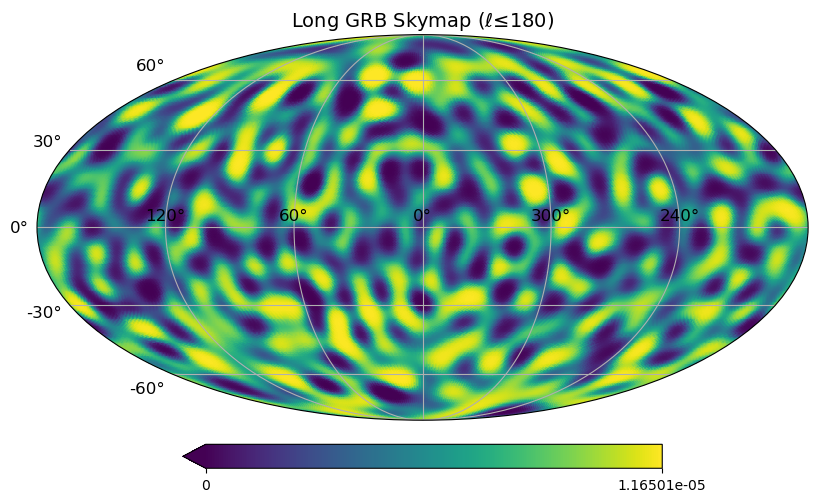

In [25]:
# blur skymap up to multipole lmax

lmaxfactor = 1 # 1 means same resolution as GW map
lmax = lmaxfactor*26 # GW map resolution is up to l=26 (??? check literature)

# take spherical harmonics expansion up to lmax
alm_lsq = hp.sphtfunc.map2alm_lsq(GRB_full_sm, lmax=lmax, mmax=lmax, tol=1e-100)
alm_real = alm_lsq[0]

GRB_sm_lmax = hp.alm2map(alm_real, nside)

# normalize skymap
normalized_GRB_map = GRB_sm_lmax / (GRB_sm_lmax.sum())

# plot, Mollweide
hp.projview(
    normalized_GRB_map,
    norm="hist",
    graticule = True,
    graticule_labels = True,
    title='GRB Skymap ($\ell ≤ 26$)',
    projection_type='mollweide',
    min=0)

# Save GRB skymap for later correlation
norm_GRB_skymap = normalized_GRB_map

# do the same for short and long GRBs separately
# Short GRBs
alm_lsq_short = hp.sphtfunc.map2alm_lsq(GRB_short_sm, lmax=lmax, mmax=lmax, tol=1e-100)
alm_real_short = alm_lsq_short[0]
GRB_sm_lmax_short = hp.alm2map(alm_real_short, nside)
# normalize skymap
normalized_GRB_map_short = GRB_sm_lmax_short / (GRB_sm_lmax_short.sum())
# plot, Mollweide
hp.projview(    
    normalized_GRB_map_short,
    norm="hist",
    graticule = True,
    graticule_labels = True,
    title='Short GRB Skymap ($\ell ≤ 180$)',
    projection_type='mollweide',
    min=0)
# Long GRBs
alm_lsq_long = hp.sphtfunc.map2alm_lsq(GRB_long_sm, lmax=lmax, mmax=lmax, tol=1e-100)
alm_real_long = alm_lsq_long[0]
GRB_sm_lmax_long = hp.alm2map(alm_real_long, nside)
# normalize skymap
normalized_GRB_map_long = GRB_sm_lmax_long / (GRB_sm_lmax_long.sum())
# plot, Mollweide
hp.projview(    
    normalized_GRB_map_long,
    norm="hist",
    graticule = True,
    graticule_labels = True,
    title='Long GRB Skymap ($\ell ≤ 180$)',
    projection_type='mollweide',
    min=0)  

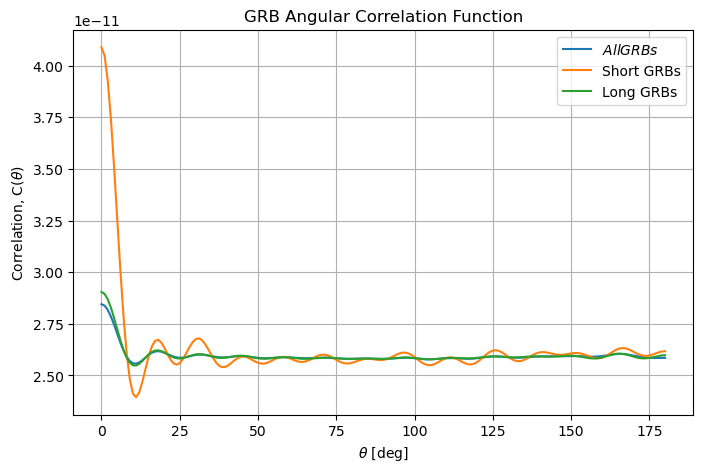

In [26]:
# take power spectrum C_l from a_lm
cl = hp.alm2cl(alm_real)
#print(cl)

def corr_func(theta, Cl):
    c = 0
    for l in range(len(Cl)):
        c += (1 + 2*l)*Cl[l]*legendre(l)(np.cos(theta))/(4*np.pi)
    return c
# plot correlation function
theta_vals = np.linspace(0, 180, 180)
y_vals_all = corr_func(np.pi*theta_vals/180, cl)
y_vals_short = corr_func(np.pi*theta_vals/180, hp.alm2cl(alm_real_short))
y_vals_long = corr_func(np.pi*theta_vals/180, hp.alm2cl(alm_real_long))

plt.figure(figsize=(8, 5))
plt.plot(theta_vals, y_vals_all, label='$All GRBs$')
plt.plot(theta_vals, y_vals_short, label='Short GRBs')
plt.plot(theta_vals, y_vals_long, label='Long GRBs')

plt.xlabel(r'$\theta$ [deg]')
plt.ylabel(r'Correlation, C($\theta$)')
plt.title('GRB Angular Correlation Function')
plt.legend()
plt.grid(True)
plt.show()

# Start simulating the GRBs (100sets)

Fit parameters (A1, mu1, sigma1, A2, mu2, sigma2):
[2.26801801e+02 8.24764109e-02 7.18126723e-01 6.12245458e+02
 1.51106306e+00 4.56912002e-01]


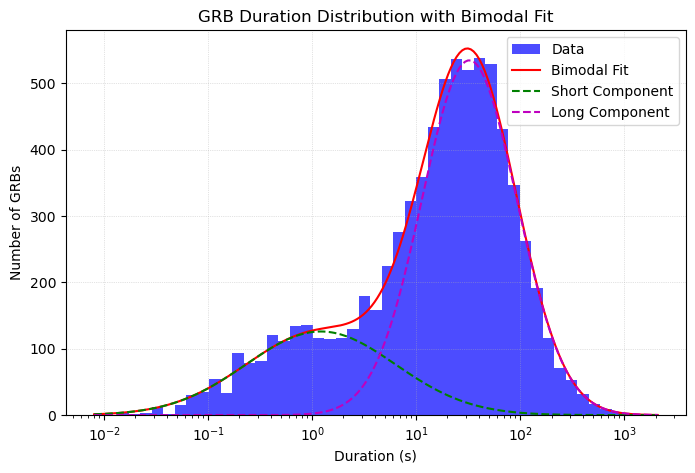

In [14]:
# obtain the duration distribution and fit a bimodal Gaussian to it
from scipy.optimize import curve_fit
from scipy.stats import norm

# plot the duration distribution in log scale for the duration axis
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

# Create log-spaced bins from the minimum to the maximum duration value
bins = np.logspace(np.log10(duration.min()), np.log10(duration.max()), 50)
# Calculate histogram
counts, bin_edges = np.histogram(duration, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram using the pre-calculated values
ax.hist(duration, bins=bins, color="blue", alpha=0.7, label="Data")

# Define the bimodal Gaussian function (sum of two Gaussians)
def bimodal_log(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * norm.pdf(np.log10(x), mu1, sigma1) +
            A2 * norm.pdf(np.log10(x), mu2, sigma2))

# Initial guesses for the parameters
# Based on the visual separation of short (<2s) and long (>2s) GRBs
p0 = [
    len(x_short), np.log10(0.3), 0.5,  # A1, mu1, sigma1 for short GRBs
    len(x_long), np.log10(30), 0.5    # A2, mu2, sigma2 for long GRBs
]

# Fit the bimodal function to the histogram data
# We use the log of bin_centers for the x-data in the fit function
try:
    popt, pcov = curve_fit(bimodal_log, bin_centers, counts, p0=p0)
    
    # Plot the fitted curve
    x_fit = np.logspace(np.log10(duration.min()), np.log10(duration.max()), 200)
    y_fit = bimodal_log(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'r-', label='Bimodal Fit')

    # Plot individual components of the fit
    y_fit1 = popt[0] * norm.pdf(np.log10(x_fit), popt[1], popt[2])
    y_fit2 = popt[3] * norm.pdf(np.log10(x_fit), popt[4], popt[5])
    ax.plot(x_fit, y_fit1, 'g--', label='Short Component')
    ax.plot(x_fit, y_fit2, 'm--', label='Long Component')
    
    print("Fit parameters (A1, mu1, sigma1, A2, mu2, sigma2):")
    print(popt)

except RuntimeError:
    print("Fit failed. Could not find optimal parameters.")


ax.set_xscale("log")
ax.set_xlabel("Duration (s)")
ax.set_ylabel("Number of GRBs")
ax.set_title("GRB Duration Distribution with Bimodal Fit")
ax.legend()
plt.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
plt.show()


Gamma fit parameters: a=1.4854929871004634, loc=0, scale=1.2987770278421298


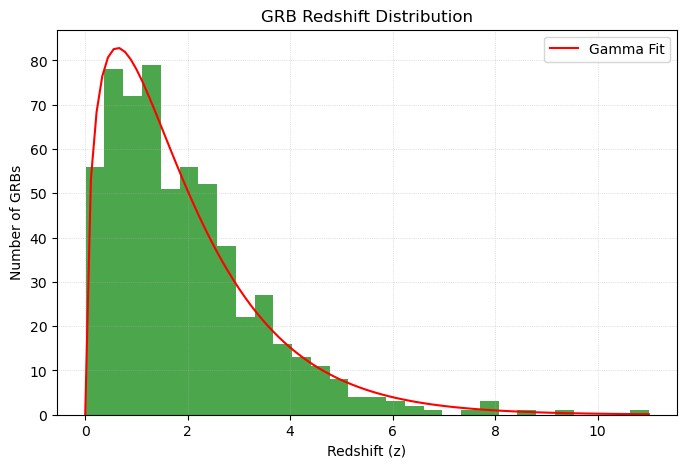

In [15]:
# plot and fit the redshift distribution for all GRBs

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
# filter out invalid redshift values
valid_z_mask = np.isfinite(z) & (z != -999)
z_valid = z[valid_z_mask]
ax.hist(z_valid, bins=30, color="green", alpha=0.7)
ax.set_xlabel("Redshift (z)")
ax.set_ylabel("Number of GRBs")
ax.set_title("GRB Redshift Distribution")
# fit a gamma distribution to the redshift data
from scipy.stats import gamma
a, loc, scale = gamma.fit(z_valid, floc=0)  # fix location to 0
x_fit = np.linspace(0, z_valid.max(), 100)
y_fit = gamma.pdf(x_fit, a, loc=loc, scale=scale) * len(z_valid) * (z_valid.max() / 30)  # scale to histogram
# print the fit parameters
print(f"Gamma fit parameters: a={a}, loc={loc}, scale={scale}")
ax.plot(x_fit, y_fit, 'r-', label='Gamma Fit')
ax.legend()
plt.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
plt.show()

## Warning: 100 sets of data takes a lot of computation power in a short time

### The 4250 seed prevents those strange spikes you've seen

In [27]:
# simulating 100 sets of events based on the observed distributions

# This block generates 100 isotropic GRB realizations, samples
# duration and redshift for each event from the fitted distributions,
# and computes their alm coefficients up to lmax.

from scipy.stats import gamma
np.random.seed(4250)  # for reproducibility

# number of realizations for the fiducial isotropic hypothesis
num_realizations = 100

# number of GRBs per realization = size of your observed sample
num_simulated_grbs = len(duration)
print(f"Each realization: {num_simulated_grbs} simulated GRBs.")

alm_sims = []         # all GRBs
alm_sims_short = []   # short GRBs only
alm_sims_long = []    # long GRBs only

sim_durations_all = []   # store durations for all GRBs (per realization)
sim_redshifts_all = []   # store redshifts for all GRBs (per realization)

nside = 128  # must match nside used for observed map
lmax = 26   # must match lmax used for observed map

# Parameters from the duration fit (bimodal log-normal)
A1, mu1, sigma1, A2, mu2, sigma2 = popt
prob_short = A1 / (A1 + A2)

# Parameters from the redshift fit (gamma)
# a, loc, scale are assumed already defined

for i_real in range(num_realizations):
    # Draw how many short/long GRBs in this realization
    num_short_sim = np.random.binomial(num_simulated_grbs, prob_short)
    num_long_sim = num_simulated_grbs - num_short_sim

    # ---------------------------------------
    # 1) Isotropic GRB positions on the sphere
    # ---------------------------------------
    u_rand = np.random.uniform(0.0, 1.0, num_simulated_grbs)
    v_rand = np.random.uniform(0.0, 1.0, num_simulated_grbs)

    l_rad = 2.0 * np.pi * v_rand
    b_rad = np.arcsin(2.0 * u_rand - 1.0)

    sim_coords = SkyCoord(l=l_rad * u.rad, b=b_rad * u.rad, frame="galactic").icrs
    ra_rad  = sim_coords.ra.radian
    dec_rad = sim_coords.dec.radian

    # ---------------------------------------
    # 2) Sample duration and redshift
    # ---------------------------------------
    # Duration from bimodal log-normal fit
    log_dur_short = np.random.normal(mu1, sigma1, num_short_sim)
    log_dur_long  = np.random.normal(mu2, sigma2, num_long_sim)
    sim_durations = 10.0 ** np.concatenate([log_dur_short, log_dur_long])
    np.random.shuffle(sim_durations)
    sim_durations_all.append(sim_durations)

    # Redshift from gamma fit
    sim_redshifts = gamma.rvs(a, loc=loc, scale=scale, size=num_simulated_grbs)
    sim_redshifts_all.append(sim_redshifts)

    # Split positions into "short" and "long" according to the same counts
    ra_rad_short  = ra_rad[:num_short_sim]
    dec_rad_short = dec_rad[:num_short_sim]
    ra_rad_long   = ra_rad[num_short_sim:]
    dec_rad_long  = dec_rad[num_short_sim:]

    # ---------------------------------------
    # 3) Build HEALPix probability maps:
    #    - all GRBs
    #    - short GRBs only
    #    - long GRBs only
    # ---------------------------------------
    npix = hp.nside2npix(nside)

    # All GRBs
    theta_all = np.pi / 2.0 - dec_rad
    phi_all   = ra_rad
    ipix_all = hp.ang2pix(nside, theta_all, phi_all, nest=False)
    counts_map_all = np.zeros(npix, dtype=float)
    np.add.at(counts_map_all, ipix_all, 1.0)
    total_all = counts_map_all.sum()
    if total_all > 0:
        skymap_all = counts_map_all / total_all
    else:
        skymap_all = counts_map_all

    # Short GRBs
    theta_short = np.pi / 2.0 - dec_rad_short
    phi_short   = ra_rad_short
    ipix_short = hp.ang2pix(nside, theta_short, phi_short, nest=False)
    counts_map_short = np.zeros(npix, dtype=float)
    np.add.at(counts_map_short, ipix_short, 1.0)
    total_short = counts_map_short.sum()
    if total_short > 0:
        skymap_short = counts_map_short / total_short
    else:
        skymap_short = counts_map_short

    # Long GRBs
    theta_long = np.pi / 2.0 - dec_rad_long
    phi_long   = ra_rad_long
    ipix_long = hp.ang2pix(nside, theta_long, phi_long, nest=False)
    counts_map_long = np.zeros(npix, dtype=float)
    np.add.at(counts_map_long, ipix_long, 1.0)
    total_long = counts_map_long.sum()
    if total_long > 0:
        skymap_long = counts_map_long / total_long
    else:
        skymap_long = counts_map_long

    # ---------------------------------------
    # 4) Blur to l <= lmax and get alm
    # ---------------------------------------
    alm_all_lsq   = hp.sphtfunc.map2alm_lsq(skymap_all,   lmax=lmax, mmax=lmax)
    alm_short_lsq = hp.sphtfunc.map2alm_lsq(skymap_short, lmax=lmax, mmax=lmax)
    alm_long_lsq  = hp.sphtfunc.map2alm_lsq(skymap_long,  lmax=lmax, mmax=lmax)

    alm_sims.append(alm_all_lsq[0])
    alm_sims_short.append(alm_short_lsq[0])
    alm_sims_long.append(alm_long_lsq[0])

    if (i_real + 1) % 10 == 0:
        print(f"Computed alm for {i_real+1}/{num_realizations} realizations.")

Each realization: 7545 simulated GRBs.
Computed alm for 10/100 realizations.
Computed alm for 20/100 realizations.
Computed alm for 30/100 realizations.
Computed alm for 40/100 realizations.
Computed alm for 50/100 realizations.
Computed alm for 60/100 realizations.
Computed alm for 70/100 realizations.
Computed alm for 80/100 realizations.
Computed alm for 90/100 realizations.
Computed alm for 100/100 realizations.


In [28]:
print(len(alm_sims))  # should be 100
print(len(alm_sims[0]))  # length of alm array for lmax=26
print(len(alm_real))  # should be 100
print(len(sim_redshifts_all))
print(len(sim_redshifts_all[0]))  # should be num_simulated_grbs
print(len(alm_sims_short))  # should be 100
print(len(alm_sims_short[0]))  # length of alm array for lmax
print(len(alm_sims_long))  # should be 100
print(len(alm_sims_long[0]))  # length of alm array for lmax

100
378
378
100
7545
100
378
100
378


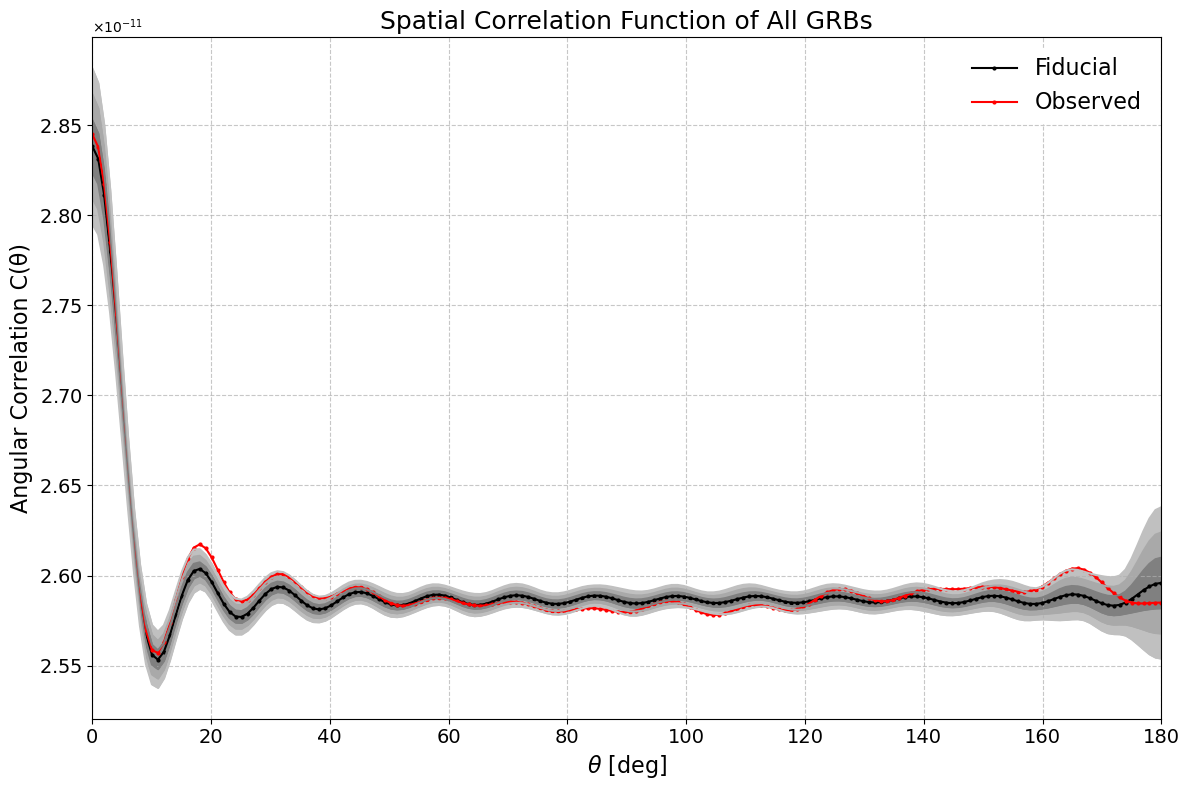

In [30]:
# ------------------------------------------------------------
# 1. Theta grid and correlation function from Cl
# ------------------------------------------------------------
import scipy.stats as stats
import matplotlib.ticker as mticker
theta_vals = np.linspace(0.0, 180.0, 180)  # in degrees
theta_rad = np.deg2rad(theta_vals)         # in radians


def corr_func(theta, Cl):
    """
    Compute C(theta) from a power spectrum Cl.

    Parameters
    ----------
    theta : float or array, radians
        Angular separation(s) in radians.
    Cl : array-like, shape (Lmax+1,)
        Angular power spectrum C_l.

    Returns
    -------
    C(theta) with the same shape as theta.
    """
    theta = np.asarray(theta)
    Lmax = len(Cl) - 1
    c = 0.0
    for l in range(Lmax + 1):
        P_l = legendre(l)(np.cos(theta))   # P_l(cos theta)
        c += (2*l + 1) * Cl[l] * P_l / (4.0 * np.pi)
    return c


# ------------------------------------------------------------
# 2. Compute Cl and C(theta) for observed and simulations
#    (all, short, long)
# ------------------------------------------------------------

# Observed C_l and C(theta)
cl_obs       = hp.alm2cl(alm_real)         # all GRBs
cl_obs_short = hp.alm2cl(alm_real_short)   # short GRBs
cl_obs_long  = hp.alm2cl(alm_real_long)    # long GRBs

cf_obs       = corr_func(theta_rad, cl_obs)
cf_obs_short = corr_func(theta_rad, cl_obs_short)
cf_obs_long  = corr_func(theta_rad, cl_obs_long)

# Simulated C_l and C(theta)
cl_sims       = np.array([hp.alm2cl(a) for a in alm_sims])        # (N_sims, Lmax+1)
cl_sims_short = np.array([hp.alm2cl(a) for a in alm_sims_short])
cl_sims_long  = np.array([hp.alm2cl(a) for a in alm_sims_long])

cf_sims       = np.array([corr_func(theta_rad, Cl) for Cl in cl_sims])       # (N_sims, N_theta)
cf_sims_short = np.array([corr_func(theta_rad, Cl) for Cl in cl_sims_short])
cf_sims_long  = np.array([corr_func(theta_rad, Cl) for Cl in cl_sims_long])

# DataFrames: rows = theta index, cols = simulation index
df_cf       = pd.DataFrame(cf_sims.T)
df_cf_short = pd.DataFrame(cf_sims_short.T)
df_cf_long  = pd.DataFrame(cf_sims_long.T)

obs_cf_df       = pd.DataFrame({"theta_deg": theta_vals, "cf": cf_obs})
obs_cf_df_short = pd.DataFrame({"theta_deg": theta_vals, "cf": cf_obs_short})
obs_cf_df_long  = pd.DataFrame({"theta_deg": theta_vals, "cf": cf_obs_long})


# ------------------------------------------------------------
# 3. Helper to do gamma fit at all theta for a given class
# ------------------------------------------------------------

def compute_gamma_bands(df_cf_class, obs_cf_df_class, theta_vals, n_scale=1e11):
    """
    For a given set of simulated correlation functions (df_cf_class)
    and the corresponding observed correlation function (obs_cf_df_class),
    fit a gamma distribution at each theta and return the mean and
    1/2/3-sigma bands.
    """
    theta_deg = theta_vals
    df_gamma_fit = pd.DataFrame()
    df_gamma_fit["theta_deg"] = theta_deg

    shapes, locs, scales, pvals = [], [], [], []

    for idx in range(len(theta_deg)):
        obs = obs_cf_df_class.loc[idx, "cf"]

        data = df_cf_class.loc[idx].to_numpy()
        data_scaled = data * n_scale

        shape, loc, scale = stats.gamma.fit(data_scaled)

        loc   /= n_scale
        scale /= n_scale

        cdf_obs = stats.gamma.cdf(obs, shape, loc=loc, scale=scale)
        p_value = 2.0 * min(cdf_obs, 1.0 - cdf_obs)

        shapes.append(shape)
        locs.append(loc)
        scales.append(scale)
        pvals.append(p_value)

    df_gamma_fit["shape"]   = shapes
    df_gamma_fit["loc"]     = locs
    df_gamma_fit["scale"]   = scales
    df_gamma_fit["p_value"] = pvals

    # mean and variance from fitted gamma at each theta
    df_gamma_fit["mean"] = stats.gamma.mean(
        df_gamma_fit["shape"], df_gamma_fit["loc"], df_gamma_fit["scale"]
    )
    df_gamma_fit["var"] = stats.gamma.var(
        df_gamma_fit["shape"], df_gamma_fit["loc"], df_gamma_fit["scale"]
    )

    std_plot = np.sqrt(df_gamma_fit["var"])
    ave_plot = df_gamma_fit["mean"]

    sigma_1p = ave_plot + std_plot
    sigma_1m = ave_plot - std_plot
    sigma_2p = ave_plot + 2.0 * std_plot
    sigma_2m = ave_plot - 2.0 * std_plot
    sigma_3p = ave_plot + 3.0 * std_plot
    sigma_3m = ave_plot - 3.0 * std_plot

    result = {
        "theta_deg": df_gamma_fit["theta_deg"].to_numpy(float),
        "mean":      ave_plot.to_numpy(float),
        "sigma_1p":  sigma_1p.to_numpy(float),
        "sigma_1m":  sigma_1m.to_numpy(float),
        "sigma_2p":  sigma_2p.to_numpy(float),
        "sigma_2m":  sigma_2m.to_numpy(float),
        "sigma_3p":  sigma_3p.to_numpy(float),
        "sigma_3m":  sigma_3m.to_numpy(float),
        "obs":       obs_cf_df_class["cf"].to_numpy(float),
        "p_value":   df_gamma_fit["p_value"].to_numpy(float),
    }
    return result


# Compute bands for all, short, and long GRBs
bands_all   = compute_gamma_bands(df_cf,       obs_cf_df,       theta_vals)
bands_short = compute_gamma_bands(df_cf_short, obs_cf_df_short, theta_vals)
bands_long  = compute_gamma_bands(df_cf_long,  obs_cf_df_long,  theta_vals)


# ------------------------------------------------------------
# 4. Helper to plot one class (all / short / long)
# ------------------------------------------------------------

def plot_bands(bands, title="", filename=None):
    theta_arr    = bands["theta_deg"]
    ave_arr      = bands["mean"]
    sigma_1p_arr = bands["sigma_1p"]
    sigma_1m_arr = bands["sigma_1m"]
    sigma_2p_arr = bands["sigma_2p"]
    sigma_2m_arr = bands["sigma_2m"]
    sigma_3p_arr = bands["sigma_3p"]
    sigma_3m_arr = bands["sigma_3m"]
    obs_arr      = bands["obs"]

    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Fiducial (mean) curve
    plt.plot(theta_arr, ave_arr, ".-", markersize=4,
             color="black", label="Fiducial")

    # Observed curve
    plt.plot(theta_arr, obs_arr, "r.-", markersize=4, label="Observed")

    # 1σ, 2σ, 3σ lines
    plt.plot(theta_arr, sigma_1p_arr, color="gray")
    plt.plot(theta_arr, sigma_1m_arr, color="gray")
    plt.plot(theta_arr, sigma_2p_arr, color="darkgray")
    plt.plot(theta_arr, sigma_2m_arr, color="darkgray")
    plt.plot(theta_arr, sigma_3p_arr, color="silver")
    plt.plot(theta_arr, sigma_3m_arr, color="silver")

    # Filled bands
    plt.fill_between(theta_arr, sigma_3m_arr, sigma_3p_arr, color="silver")
    plt.fill_between(theta_arr, sigma_2m_arr, sigma_2p_arr, color="darkgray")
    plt.fill_between(theta_arr, sigma_1m_arr, sigma_1p_arr, color="gray")

    plt.xlim(0, 180)
    plt.ylim(1.75e-11,3.05e-11)
    
    # Use linear scale and scientific notation for y-axis
    plt.yscale("linear")
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1,1))
    ax.yaxis.set_major_formatter(formatter)

    plt.xlabel(r"$\theta$ [deg]", fontsize=16)
    plt.ylabel("Angular Correlation C(θ)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if title:
        plt.title(title, fontsize=18)
    plt.grid(which="both", alpha=0.7, linestyle="--")
    plt.legend(loc=1, frameon=True, framealpha=1.0, edgecolor="white", fontsize=16)

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=600)
        plt.show()
    else:
        plt.show()


# ------------------------------------------------------------
# 5. Make the three plots: all / short / long
# ------------------------------------------------------------

plot_bands(bands_all,   title="Spatial Correlation Function of All GRBs",   filename='CF_all.png')  # or "cf_all_mean_gamma.png"
#plot_bands(bands_short, title="Spatial Correlation Function of Short GRBs", filename='CF_short.png')  # or "cf_short_mean_gamma.png"
#plot_bands(bands_long,  title="Spatial Correlation Function of Long GRBs",  filename='CF_long.png')  # or "cf_long_mean_gamma.png"

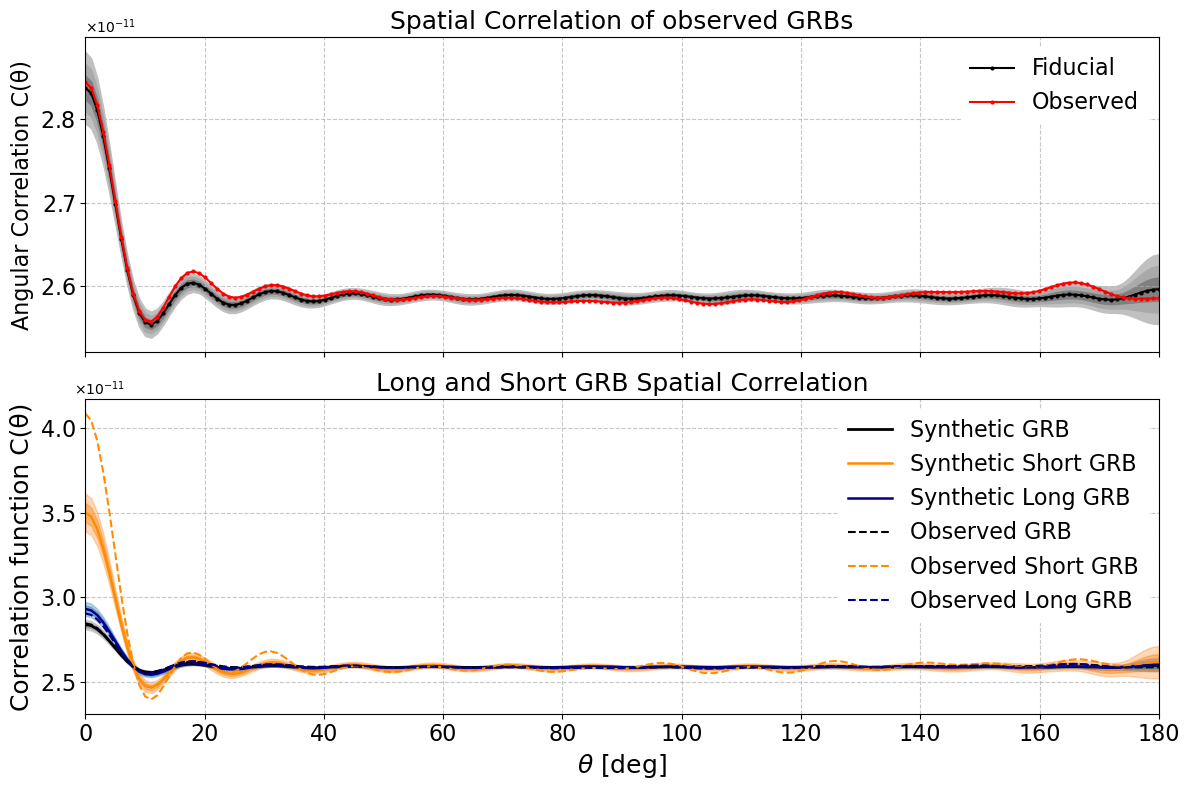

In [33]:
# Create a figure with two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# ------------------------------------------------------------
# Top Subplot: Spatial Correlation Function of All GRBs (from cell 10)
# ------------------------------------------------------------
theta_arr_all = bands_all["theta_deg"]

# Filled bands for "All GRBs"
ax1.fill_between(theta_arr_all, bands_all["sigma_3m"], bands_all["sigma_3p"], color="silver", label="3σ band")
ax1.fill_between(theta_arr_all, bands_all["sigma_2m"], bands_all["sigma_2p"], color="darkgray", label="2σ band")
ax1.fill_between(theta_arr_all, bands_all["sigma_1m"], bands_all["sigma_1p"], color="gray", label="1σ band")

# Fiducial (mean) and Observed curves for "All GRBs"
ax1.plot(theta_arr_all, bands_all["mean"], ".-", markersize=4, color="black", label="Fiducial")
ax1.plot(theta_arr_all, bands_all["obs"], "r.-", markersize=4, label="Observed")

# Axes styling for the top subplot
ax1.set_xlim(0, 180)
ax1.set_yscale("linear")
formatter1 = mticker.ScalarFormatter(useMathText=True)
formatter1.set_powerlimits((-1, 1))
ax1.yaxis.set_major_formatter(formatter1)
ax1.set_ylabel("Angular Correlation C(θ)", fontsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_title("Spatial Correlation of observed GRBs", fontsize=18)
ax1.grid(which="both", alpha=0.7, linestyle="--")
# hide the sigma bands in the legend
handles, labels = ax1.get_legend_handles_labels()
new_handles = []
new_labels = []
for handle, label in zip(handles, labels):
    if "σ band" not in label:
        new_handles.append(handle)
        new_labels.append(label)
ax1.legend(new_handles, new_labels, loc=1, frameon=True, framealpha=1.0, edgecolor="white", fontsize=16)


# ------------------------------------------------------------
# Bottom Subplot: Comparison of All, Short, and Long GRBs (from cell 11)
# ------------------------------------------------------------
theta_arr = bands_all["theta_deg"]

# === 2σ bands ===
ax2.fill_between(
    theta_arr, bands_all["sigma_2m"], bands_all["sigma_2p"],
    color="darkgray", alpha=0.5
)
ax2.fill_between(
    theta_arr, bands_short["sigma_2m"], bands_short["sigma_2p"],
    color="tab:orange", alpha=0.3
)
ax2.fill_between(
    theta_arr, bands_long["sigma_2m"], bands_long["sigma_2p"],
    color="tab:blue", alpha=0.3
)

# === 1σ bands ===
ax2.fill_between(
    theta_arr, bands_all["sigma_1m"], bands_all["sigma_1p"],
    color="gray", alpha=0.5, label="All GRBs (1σ, 2σ bands)"
)
ax2.fill_between(
    theta_arr, bands_short["sigma_1m"], bands_short["sigma_1p"],
    color="tab:orange", alpha=0.4, label="Short GRBs (1σ, 2σ bands)"
)
ax2.fill_between(
    theta_arr, bands_long["sigma_1m"], bands_long["sigma_1p"],
    color="tab:blue", alpha=0.4, label="Long GRBs (1σ, 2σ bands)"
)

# === Mean (fiducial) curves ===
ax2.plot(theta_arr, bands_all["mean"],   color="black",      lw=2.0, label="Synthetic GRB")
ax2.plot(theta_arr, bands_short["mean"], color="darkorange", lw=1.8, label="Synthetic Short GRB")
ax2.plot(theta_arr, bands_long["mean"],  color="darkblue",   lw=1.8, label="Synthetic Long GRB")

# === Observed curves ===
ax2.plot(theta_arr, bands_all["obs"],   "k--",        lw=1.5, label="Observed GRB")
ax2.plot(theta_arr, bands_short["obs"], "--", color="darkorange", lw=1.5, label="Observed Short GRB")
ax2.plot(theta_arr, bands_long["obs"],  "--", color="darkblue",   lw=1.5, label="Observed Long GRB")

# Axes styling for the bottom subplot
ax2.set_yscale("linear")
formatter2 = mticker.ScalarFormatter(useMathText=True)
formatter2.set_powerlimits((-3, 4))
ax2.yaxis.set_major_formatter(formatter2)
ax2.yaxis.get_offset_text().set_x(-0.01)

fontsize = 16
ax2.set_xlabel(r"$\theta$ [deg]", fontsize=18)
ax2.set_ylabel("Correlation function C(θ)", fontsize=18)
ax2.tick_params(axis='both', labelsize=fontsize)

ax2.set_title("Long and Short GRB Spatial Correlation", fontsize=18)
ax2.grid(which="both", alpha=0.7, linestyle="--")
# hide the sigma bands in the legend
handles, labels = ax2.get_legend_handles_labels()
new_handles = []
new_labels = []
for handle, label in zip(handles, labels):
    if "σ band" not in label:
        new_handles.append(handle)
        new_labels.append(label)
ax2.legend(new_handles, new_labels, loc=1, frameon=True, framealpha=1.0, edgecolor="white", fontsize=16)
# Final adjustments and save
plt.tight_layout()
plt.savefig("grb_cf_subplots.png", dpi=600)
plt.show()
plt.close()

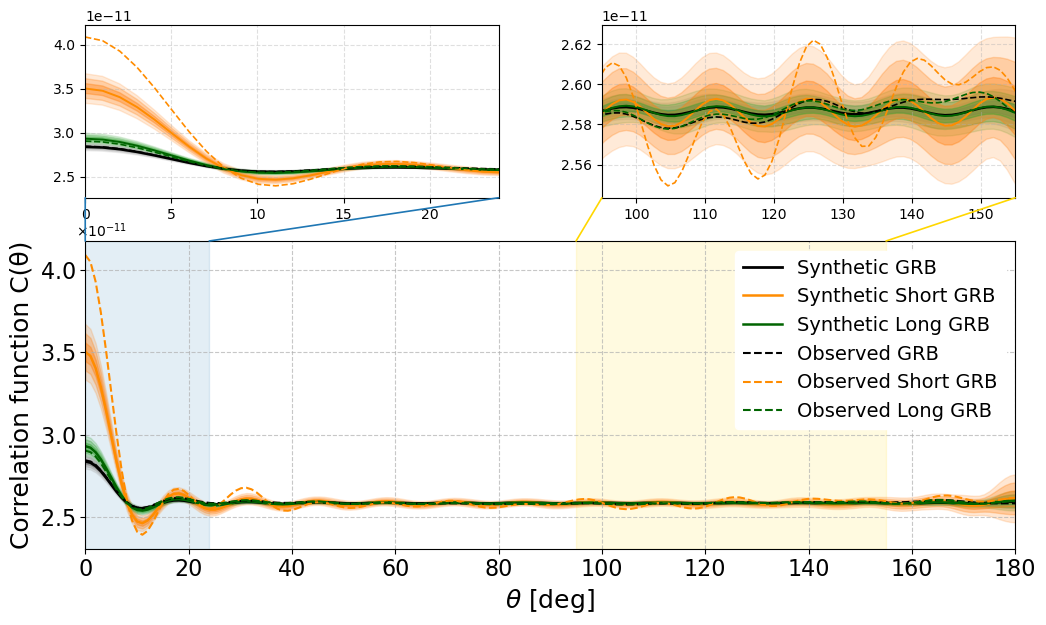

In [35]:
# --- Single-panel (All/Short/Long) + focus plots (bands included) ---
# Next cell after your bands_* are defined.
# Assumes you already have:
#   bands_all, bands_short, bands_long
#   plt, np, mticker
#   (optionally) theta_arr

from matplotlib.patches import ConnectionPatch

# ============================================================
# EDIT HERE
# Change number of focus plots and their x-ranges (in degrees)
# Focus indication colors -> BLUE and YELLOW
# ============================================================
focus_cfg = [
    dict(xlim=(0, 24),   color="tab:blue"),
    dict(xlim=(95, 155), color="gold"),
]

# Global knobs
DRAW_CONNECTORS = True
SHADE_FOCUS_ON_MAIN = True
SHADE_ALPHA = 0.12

# FIX: make focus row sit visually higher relative to the main panel
# by giving the focus row a bit more height and increasing vertical gap.
FOCUS_HEIGHT_RATIOS = (1.15, 2.05)  # focus row slightly taller; main slightly shorter
FOCUS_HSPACE = 0.18                 # increase gap to push main down
FOCUS_WSPACE = 0.25
CONNECTOR_LW = 1.2

# Band alphas for focus (slightly lighter than main)
FOCUS_ALPHA_3 = 0.20
FOCUS_ALPHA_2 = 0.32
FOCUS_ALPHA_1 = 0.42

# ------------------------------------------------------------
# Reuse theta from your notebook if present
# ------------------------------------------------------------
theta_arr = theta_arr if "theta_arr" in globals() else bands_all["theta_deg"]

# ============================================================
# Helpers
# ============================================================
def auto_ylim(y_arrays, pad=0.08):
    y_min = min(np.min(y) for y in y_arrays)
    y_max = max(np.max(y) for y in y_arrays)
    rng = y_max - y_min
    if rng == 0:
        rng = abs(y_max) if y_max != 0 else 1.0
    return (y_min - pad * rng, y_max + pad * rng)

def build_group(fig, focus_cfg):
    n = len(focus_cfg)
    if n == 0:
        gs = fig.add_gridspec(1, 1)
        main_ax = fig.add_subplot(gs[0, 0])
        return main_ax, []

    gs = fig.add_gridspec(
        2, n,
        height_ratios=FOCUS_HEIGHT_RATIOS,
        hspace=FOCUS_HSPACE,
        wspace=FOCUS_WSPACE
    )
    focus_axes = [fig.add_subplot(gs[0, i]) for i in range(n)]
    main_ax = fig.add_subplot(gs[1, :])
    return main_ax, focus_axes

def connect_focus(fig, ax_main, ax_focus, xlim, color="k"):
    if not DRAW_CONNECTORS:
        return
    x0, x1 = xlim
    y_main_top = ax_main.get_ylim()[1]
    y_focus_bottom = ax_focus.get_ylim()[0]

    for x in (x0, x1):
        con = ConnectionPatch(
            xyA=(x, y_focus_bottom), coordsA=ax_focus.transData,
            xyB=(x, y_main_top),     coordsB=ax_main.transData,
            color=color, lw=CONNECTOR_LW
        )
        fig.add_artist(con)

# ============================================================
# Main panel plotting (with 1σ/2σ/3σ)
# ============================================================
def plot_main(ax):
    # --- 3σ bands ---
    ax.fill_between(theta_arr, bands_all["sigma_3m"], bands_all["sigma_3p"],
                    color="darkgray", alpha=0.25)
    ax.fill_between(theta_arr, bands_short["sigma_3m"], bands_short["sigma_3p"],
                    color="tab:orange", alpha=0.18)
    ax.fill_between(theta_arr, bands_long["sigma_3m"], bands_long["sigma_3p"],
                    color="tab:green", alpha=0.18)

    # --- 2σ bands ---
    ax.fill_between(theta_arr, bands_all["sigma_2m"], bands_all["sigma_2p"],
                    color="darkgray", alpha=0.45)
    ax.fill_between(theta_arr, bands_short["sigma_2m"], bands_short["sigma_2p"],
                    color="tab:orange", alpha=0.28)
    ax.fill_between(theta_arr, bands_long["sigma_2m"], bands_long["sigma_2p"],
                    color="tab:green", alpha=0.28)

    # --- 1σ bands ---
    ax.fill_between(theta_arr, bands_all["sigma_1m"], bands_all["sigma_1p"],
                    color="gray", alpha=0.55)
    ax.fill_between(theta_arr, bands_short["sigma_1m"], bands_short["sigma_1p"],
                    color="tab:orange", alpha=0.38)
    ax.fill_between(theta_arr, bands_long["sigma_1m"], bands_long["sigma_1p"],
                    color="tab:green", alpha=0.38)

    # --- Mean (synthetic) curves ---
    ax.plot(theta_arr, bands_all["mean"],   color="black",      lw=2.0, label="Synthetic GRB")
    ax.plot(theta_arr, bands_short["mean"], color="darkorange", lw=1.8, label="Synthetic Short GRB")
    ax.plot(theta_arr, bands_long["mean"],  color="darkgreen",  lw=1.8, label="Synthetic Long GRB")

    # --- Observed curves ---
    ax.plot(theta_arr, bands_all["obs"],   "k--", lw=1.5, label="Observed GRB")
    ax.plot(theta_arr, bands_short["obs"], "--", color="darkorange", lw=1.5, label="Observed Short GRB")
    ax.plot(theta_arr, bands_long["obs"],  "--", color="darkgreen",  lw=1.5, label="Observed Long GRB")

    # Axes styling
    ax.set_xlim(0, 180)
    ax.set_yscale("linear")
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 4))
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.get_offset_text().set_x(-0.01)

    ax.set_xlabel(r"$\theta$ [deg]", fontsize=18)
    ax.set_ylabel("Correlation function C(θ)", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(which="both", alpha=0.7, linestyle="--")

    # Legend: curves only
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc=1, frameon=True, framealpha=1.0,
              edgecolor="white", fontsize=14)

# ============================================================
# Focus panel plotting (bands + curves)
# ============================================================
def plot_focus(ax, cfg):
    x0, x1 = cfg["xlim"]
    m = (theta_arr >= x0) & (theta_arr <= x1)

    # --- 3σ bands ---
    ax.fill_between(theta_arr, bands_all["sigma_3m"], bands_all["sigma_3p"],
                    color="darkgray", alpha=FOCUS_ALPHA_3)
    ax.fill_between(theta_arr, bands_short["sigma_3m"], bands_short["sigma_3p"],
                    color="tab:orange", alpha=FOCUS_ALPHA_3 * 0.8)
    ax.fill_between(theta_arr, bands_long["sigma_3m"], bands_long["sigma_3p"],
                    color="tab:green", alpha=FOCUS_ALPHA_3 * 0.8)

    # --- 2σ bands ---
    ax.fill_between(theta_arr, bands_all["sigma_2m"], bands_all["sigma_2p"],
                    color="darkgray", alpha=FOCUS_ALPHA_2)
    ax.fill_between(theta_arr, bands_short["sigma_2m"], bands_short["sigma_2p"],
                    color="tab:orange", alpha=FOCUS_ALPHA_2 * 0.8)
    ax.fill_between(theta_arr, bands_long["sigma_2m"], bands_long["sigma_2p"],
                    color="tab:green", alpha=FOCUS_ALPHA_2 * 0.8)

    # --- 1σ bands ---
    ax.fill_between(theta_arr, bands_all["sigma_1m"], bands_all["sigma_1p"],
                    color="gray", alpha=FOCUS_ALPHA_1)
    ax.fill_between(theta_arr, bands_short["sigma_1m"], bands_short["sigma_1p"],
                    color="tab:orange", alpha=FOCUS_ALPHA_1 * 0.85)
    ax.fill_between(theta_arr, bands_long["sigma_1m"], bands_long["sigma_1p"],
                    color="tab:green", alpha=FOCUS_ALPHA_1 * 0.85)

    # --- Curves ---
    ax.plot(theta_arr, bands_all["mean"],   color="black",      lw=1.8)
    ax.plot(theta_arr, bands_short["mean"], color="darkorange", lw=1.4)
    ax.plot(theta_arr, bands_long["mean"],  color="darkgreen",  lw=1.4)

    ax.plot(theta_arr, bands_all["obs"],   "k--", lw=1.2)
    ax.plot(theta_arr, bands_short["obs"], "--", color="darkorange", lw=1.2)
    ax.plot(theta_arr, bands_long["obs"],  "--", color="darkgreen",  lw=1.2)

    ax.set_xlim(x0, x1)

    if cfg.get("ylim") is not None:
        ax.set_ylim(*cfg["ylim"])
    else:
        ax.set_ylim(*auto_ylim([
            bands_all["sigma_3m"][m], bands_all["sigma_3p"][m],
            bands_short["sigma_3m"][m], bands_short["sigma_3p"][m],
            bands_long["sigma_3m"][m], bands_long["sigma_3p"][m],
            bands_all["obs"][m], bands_short["obs"][m], bands_long["obs"][m],
        ]))

    ax.tick_params(axis='both', labelsize=10)
    ax.grid(alpha=0.4, linestyle="--")

# ============================================================
# Build figure
# ============================================================
fig = plt.figure(figsize=(12, 6.8))
ax_main, ax_focus_list = build_group(fig, focus_cfg)

plot_main(ax_main)

# Shade focus regions on main (blue/yellow)
if SHADE_FOCUS_ON_MAIN:
    for cfg in focus_cfg:
        x0, x1 = cfg["xlim"]
        ax_main.axvspan(
            x0, x1,
            color=cfg.get("color", "0.8"),
            alpha=SHADE_ALPHA,
            zorder=0
        )

# Focus panels
for axf, cfg in zip(ax_focus_list, focus_cfg):
    plot_focus(axf, cfg)

# Ensure limits are known before connecting
if len(ax_focus_list) > 0:
    fig.canvas.draw()

# Connectors (blue/yellow)
for axf, cfg in zip(ax_focus_list, focus_cfg):
    connect_focus(fig, ax_main, axf, cfg["xlim"], color=cfg.get("color", "k"))

# plt.tight_layout()
plt.savefig("grb_cf_with_focus_single_panel.png", dpi=600)
plt.show()
plt.close()


## Simulations end here 

In [ ]:
# load the real events
obs_cf_bilby = pd.read_csv("/home/dices/gw-hands-on-school-2025/GRB_galaxies/GRB_correlation_function.txt", names=["theta", "cf"], delimiter=",")
theta_deg = obs_cf_bilby["theta"] * 180 / np.pi

# load cf from the simulated events
with open(path_synthetic, 'rb') as handle:
    cf = pickle.load(handle)

df_cf = pd.DataFrame()
for key in cf.keys():
    try:
        df_cf[key] = cf[key][:, 1]
    except Exception:
        df_cf[key] = cf[key][1]

print("data is loaded")

# -------------------------------------------------------
# plot 100 cfs and the real cfs
#--------------------------------------------------------
plt.close()
plt.figure(figsize=(12, 8))
for col in df_cf.columns:
    plt.plot(theta_deg, df_cf[col])
plt.plot(theta_deg, obs_cf_bilby['cf'], lw=3, color='b', label="Real events")
plt.xlabel(r'$\theta$')
plt.ylabel('cf')
plt.yscale("log")
plt.xticks()
plt.yticks()
plt.grid()
plt.legend()
os.makedirs(savepath, exist_ok=True)
plt.savefig(savepath + "/cf_all.png")
plt.close()

In [48]:
# plot the sigma bands
import scipy.stats as stats

def corr_from_cl(theta_rad, Cl):
    """
    theta_rad : array of angles in radians, shape (N_theta,)
    Cl        : array of C_l, shape (Lmax+1,)
    """
    theta_rad = np.atleast_1d(theta_rad)
    Lmax = len(Cl) - 1
    ell = np.arange(Lmax + 1)
    mu = np.cos(theta_rad)

    # P_l(cos theta) for all l,theta -> shape (Lmax+1, N_theta)
    Pl = np.array([legendre(l)(mu) for l in ell])
    prefac = (2.0 * ell + 1.0)[:, None] / (4.0 * np.pi)

    return np.sum(prefac * Cl[:, None] * Pl, axis=0)


# -----------------------------
# 2) Observed and simulated C(theta)
# -----------------------------

theta_deg = theta_vals
theta_rad = np.deg2rad(theta_deg)

# Observed C(theta) (you already had y_vals, but recompute consistently)
cf_obs = corr_from_cl(theta_rad, cl)   # or use cf_obs = y_vals

# Treat your alm as "alm_sims":
# - If alm is 1D (single realization), wrap to shape (1, Nalm)
# - If alm is list / 2D (many realizations), use as is.
alm_array = np.asarray(alm)
if alm_array.ndim == 1:
    alm_sims = alm_array[None, :]   # shape (1, Nalm)
else:
    alm_sims = alm_array            # shape (N_sims, Nalm)

# C_l and C(theta) for each simulation
cl_sims = np.array([hp.alm2cl(a) for a in alm_sims])           # (N_sims, Lmax+1)
cf_sims = np.array([corr_from_cl(theta_rad, Cl)                # (N_sims, N_theta)
                    for Cl in cl_sims])

# Put simulations into DataFrame: rows = theta index, cols = simulation index
df_cf = pd.DataFrame(cf_sims.T)                  # shape (N_theta, N_sims)
obs_cf_df = pd.DataFrame({"theta": theta_rad,
                          "cf": cf_obs})


# -----------------------------
# 3) Gamma fit per angle
# -----------------------------
def gamma_fit(index):
    """
    Fit a gamma distribution to the distribution of C(theta_i)
    across simulations at fixed theta index.
    """
    obs = obs_cf_df.loc[index, "cf"]

    # rescale to avoid tiny numbers in fit
    n_scale = 1.0e11
    data_scaled = df_cf.loc[index].to_numpy() * n_scale

    shape, loc, scale = stats.gamma.fit(data_scaled)
    # back to original scale
    loc   /= n_scale
    scale /= n_scale

    cdf_obs = stats.gamma.cdf(obs, shape, loc=loc, scale=scale)
    p_value = 2.0 * min(cdf_obs, 1.0 - cdf_obs)
    return shape, loc, scale, p_value


df_gamma_fit = pd.DataFrame()
df_gamma_fit["theta_deg"] = theta_deg

shape_list, loc_list, scale_list, pval_list = [], [], [], []
for idx in range(len(theta_deg)):
    shape, loc, scale, p_value = gamma_fit(idx)
    shape_list.append(shape)
    loc_list.append(loc)
    scale_list.append(scale)
    pval_list.append(p_value)

df_gamma_fit["shape"]   = shape_list
df_gamma_fit["loc"]     = loc_list
df_gamma_fit["scale"]   = scale_list
df_gamma_fit["p_value"] = pval_list

# mean and variance of C(theta) from fitted gamma
df_gamma_fit["mean"] = stats.gamma.mean(
    df_gamma_fit["shape"], df_gamma_fit["loc"], df_gamma_fit["scale"]
)
df_gamma_fit["var"] = stats.gamma.var(
    df_gamma_fit["shape"], df_gamma_fit["loc"], df_gamma_fit["scale"]
)

std_plot = np.sqrt(df_gamma_fit["var"])
ave_plot = df_gamma_fit["mean"]

sigma_1p = ave_plot + std_plot
sigma_1m = ave_plot - std_plot
sigma_2p = ave_plot + 2.0 * std_plot
sigma_2m = ave_plot - 2.0 * std_plot
sigma_3p = ave_plot + 3.0 * std_plot
sigma_3m = ave_plot - 3.0 * std_plot

theta_arr    = df_gamma_fit["theta_deg"].to_numpy(float)
ave_arr      = ave_plot.to_numpy(float)
sigma_1p_arr = sigma_1p.to_numpy(float)
sigma_1m_arr = sigma_1m.to_numpy(float)
sigma_2p_arr = sigma_2p.to_numpy(float)
sigma_2m_arr = sigma_2m.to_numpy(float)
sigma_3p_arr = sigma_3p.to_numpy(float)
sigma_3m_arr = sigma_3m.to_numpy(float)
obs_arr      = cf_obs.astype(float)


# -----------------------------
# 4) Plot observed + fiducial + σ bands
# -----------------------------
plt.close("all")
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

plt.plot(theta_arr, obs_arr, "r.-", markersize=4, label="Observed")
plt.plot(theta_arr, ave_arr, ".-", markersize=4, color="black", label="Fiducial")

plt.plot(theta_arr, sigma_1p_arr, color="gray")
plt.plot(theta_arr, sigma_1m_arr, color="gray")
plt.plot(theta_arr, sigma_2p_arr, color="darkgray")
plt.plot(theta_arr, sigma_2m_arr, color="darkgray")
plt.plot(theta_arr, sigma_3p_arr, color="silver")
plt.plot(theta_arr, sigma_3m_arr, color="silver")

plt.fill_between(theta_arr, sigma_3m_arr, sigma_3p_arr, color="silver")
plt.fill_between(theta_arr, sigma_2m_arr, sigma_2p_arr, color="darkgray")
plt.fill_between(theta_arr, sigma_1m_arr, sigma_1p_arr, color="gray")

plt.xlim(0, 180)
plt.yscale("log")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel("Correlation function")
plt.grid(which="both", alpha=0.7, linestyle="--")
plt.legend(loc=1, frameon=True, framealpha=1.0, edgecolor="white")

plt.tight_layout()
plt.show()

/home/dices/anaconda3/envs/gw-school-2025/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:409: RuntimeWarning: invalid value encountered in scalar divide
  return m3 / np.power(m2, 1.5)


FitError: Optimization converged to parameters that are outside the range allowed by the distribution.

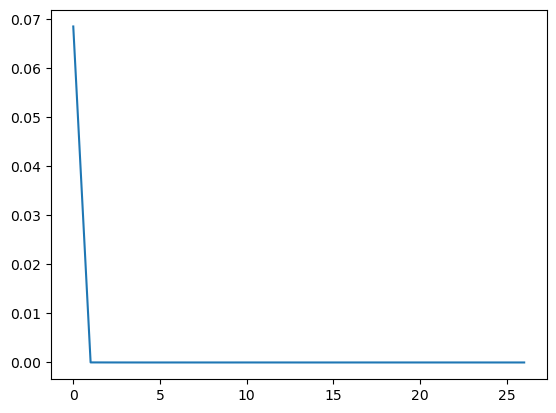

In [14]:
l_vals = [l for l in range(len(cl2))]
y_vals = cl2
plt.plot(l_vals, y_vals)

In [24]:
type(cl2)

numpy.ndarray

In [15]:
map1 = GW_skymap
map2 = sky_map2

cross_cl = hp.anafast(map1, map2=map2, pol=False)

# Get the multipoles 'ell'
ell = np.arange(len(cross_cl))

# Plot the cross-power spectrum
plt.figure(figsize=(8, 5))
plt.plot(ell, cross_cl, label='Cross-Power Spectrum (C_ell)')
#plt.plot(ell, cl2, '--', color='gray', label='True Signal C_ell')
plt.xlabel('Multipole $\ell$')
plt.ylabel('$C_{\ell}$')
plt.title('2D Angular Cross-Power Spectrum between two HEALPix maps')
plt.legend()
plt.grid(True)
plt.show()

# To get auto-power spectra of individual maps for comparison:
auto_cl_map1 = hp.anafast(map1, pol=False)
auto_cl_map2 = hp.anafast(map2, pol=False)

NameError: name 'GW_skymap' is not defined

In [ ]:
# Given a skymap



In [234]:
GW_skymap = np.load('/home/theleizurc/gw-hands-on-school-2025/grb_thing/all_skymap_norm.npy')

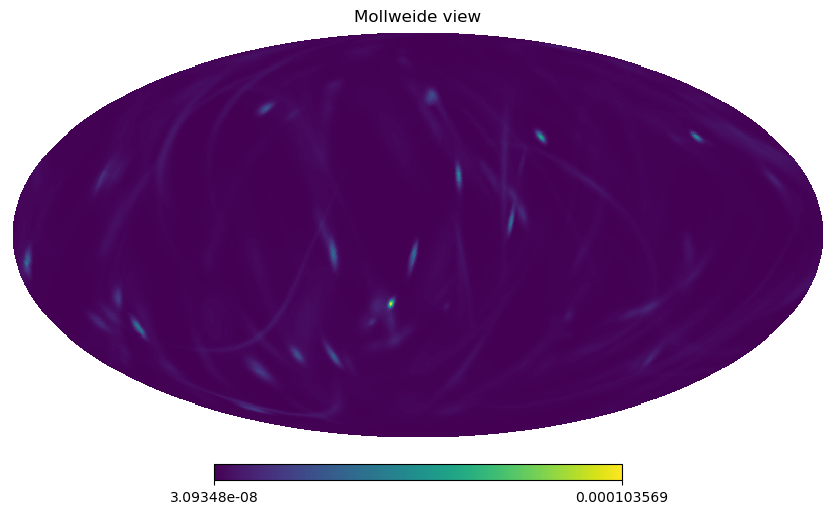

In [ ]:
skymap = GW_skymap

min_val = np.min(sky_map2)
max_val = np.max(sky_map2)
normalized_map = (sky_map2 - min_val) / (max_val - min_val)

hp.projview(
    normalized_map,
    norm="hist",
    graticule = True,
    graticule_labels = True,
    title='GRB Skymap approximated for l≤26',
    projection_type='mollweide',
    min=0)

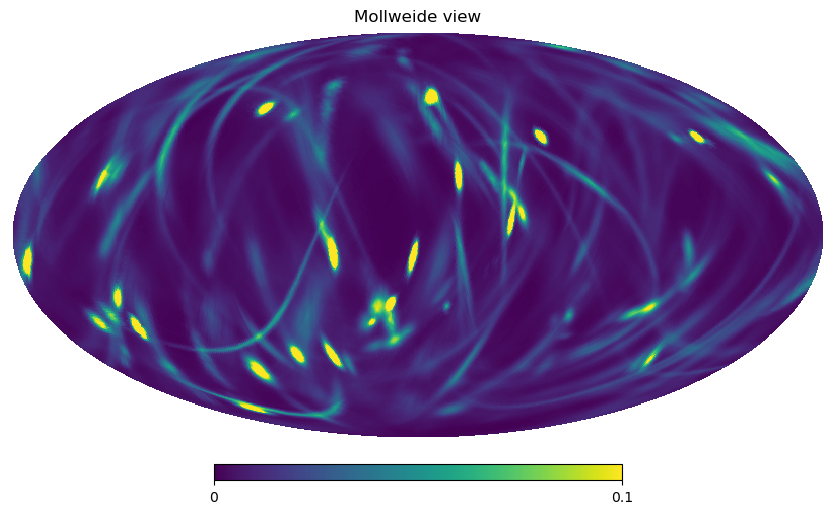

In [237]:
hp.mollview(GW_skymap,
            norm='hist',
            min=0,
            max=0.1)

## START HERE, BRIAN

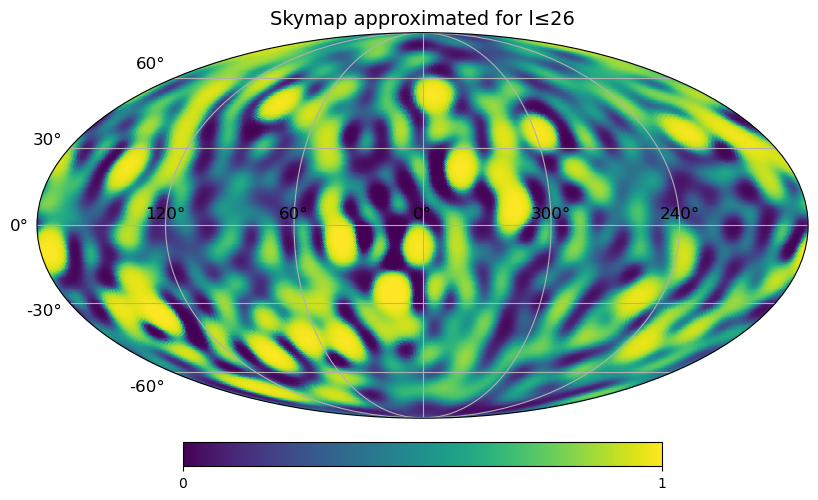

In [244]:
# Given a skymap object "sky_map"

sky_map = GW_skymap

# expan in spherical harmonics for some lmax

lmax = 26

alm_lsq = hp.sphtfunc.map2alm_lsq(sky_map, lmax = lmax, mmax = lmax) # get a_lm (multipole coefficients)
alm = alm_lsq[0]                

# rebuild skymap with limited l ≤ lmax

sky_map2 = hp.alm2map(alm, nside)

# normalize values

min_val = np.min(sky_map2)
max_val = np.max(sky_map2)
normalized_map = (sky_map2 - min_val) / (max_val - min_val)

# plot

hp.projview(
    normalized_map,
    norm="hist",
    graticule = True,
    graticule_labels = True,
    title='Skymap approximated for l≤26',
    projection_type='mollweide',
    min=0)

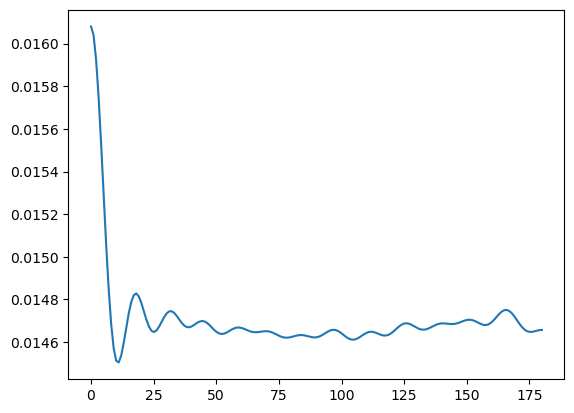

In [246]:
# find power spectrum coefficients C_l

cl = hp.alm2cl(alm)

# define correlation function c(theta)

def corr_func(theta, Cl):
    c = 0
    for l in range(len(Cl)):
        c += (1 + 2*l)*Cl[l]*legendre(l)(np.cos(theta)) / 4*np.pi
    return c

# plot correlation function

theta_vals = np.linspace(0, 180, 180)
y_vals = corr_func(np.pi*theta_vals/180, cl2)
plt.plot(theta_vals, y_vals)
